In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from result import Visualization
from models.AdEx import NeuronModel

import subprocess
from IPython.display import display, Markdown
from simulation_runner import plot_results, run_simulation, load_params

### Modeling Result

Converted parameters: {'g_L': 6.46 * nsiemens, 'vr': -85.4 * mvolt, 'th': -45. * mvolt, 'E_L': -85.4 * mvolt, 'C': 157. * pfarad, 'I': 300. * pamp}


INFO:root:building '_cython_magic_1f72eeebadb43876148c83a345e3ce2c' extension
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-strong -O2 -pipe -fPIE -isystem /opt/anaconda3/envs/brain/include -D_FORTIFY_SOURCE=2 -isystem /opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/numpy/core/include -I/opt/anaconda3/envs/brain/lib/python3.9/site-packages/brian2/synapses -I/opt/anaconda3/envs/brain/include/python3.9 -c /Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_1f72eeebadb43876148c83a345e3ce2c.cpp -o /Users/tacolab4/Library/Caches/cython/brian_extensions/Users/tacolab4/Library/Caches/cython/brian_extensions/_cython_magic_1f72eeebadb43876148c83a345e3ce2c.o -w

<Figure size 1500x800 with 0 Axes>

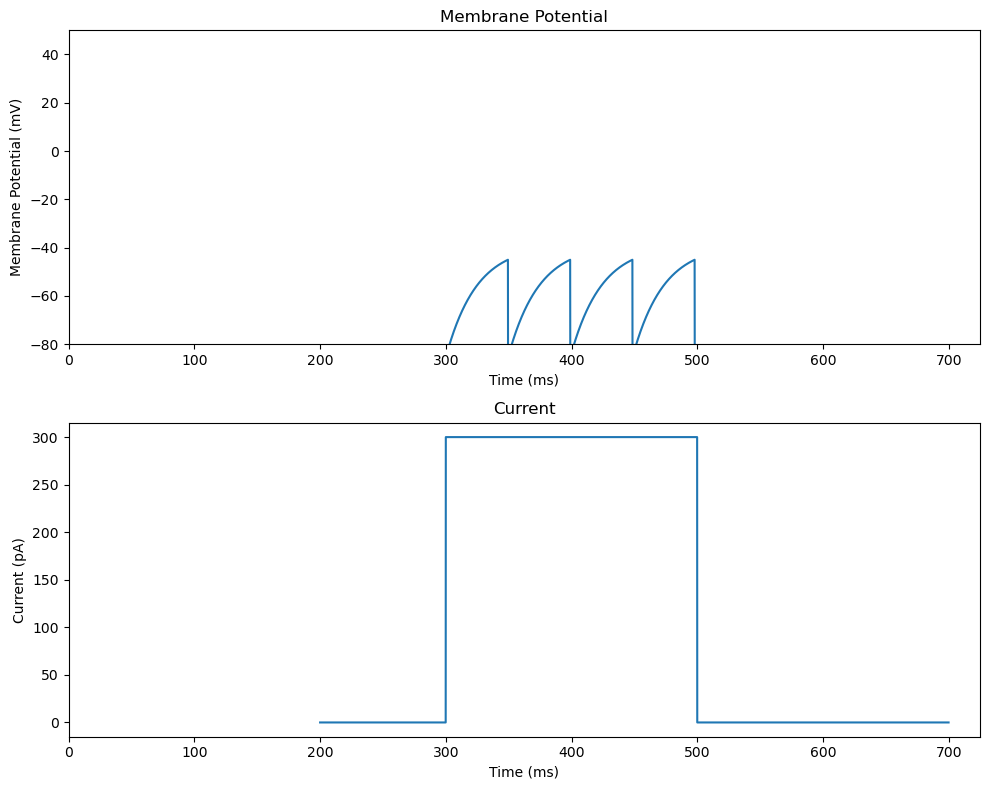

In [5]:
### Leaky Integrate and Fire 
json_file = './params/LIF.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value'] 

# simulation 
results = run_simulation(N, params, model_name)

# visualization
plot_results(results)

### AdEx spontaneous
- set I as 100pA

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -58. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T
INFO:root:creating /var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh/var/folders/gc/ccxrs945073cqwbghj93h9wr0000gn/T/brian_flag_test_6bsullrh
INFO:root:arm64-apple-darwin20.0.0-clang -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -ftree-vectorize -fPIC -fstack-protector-stron

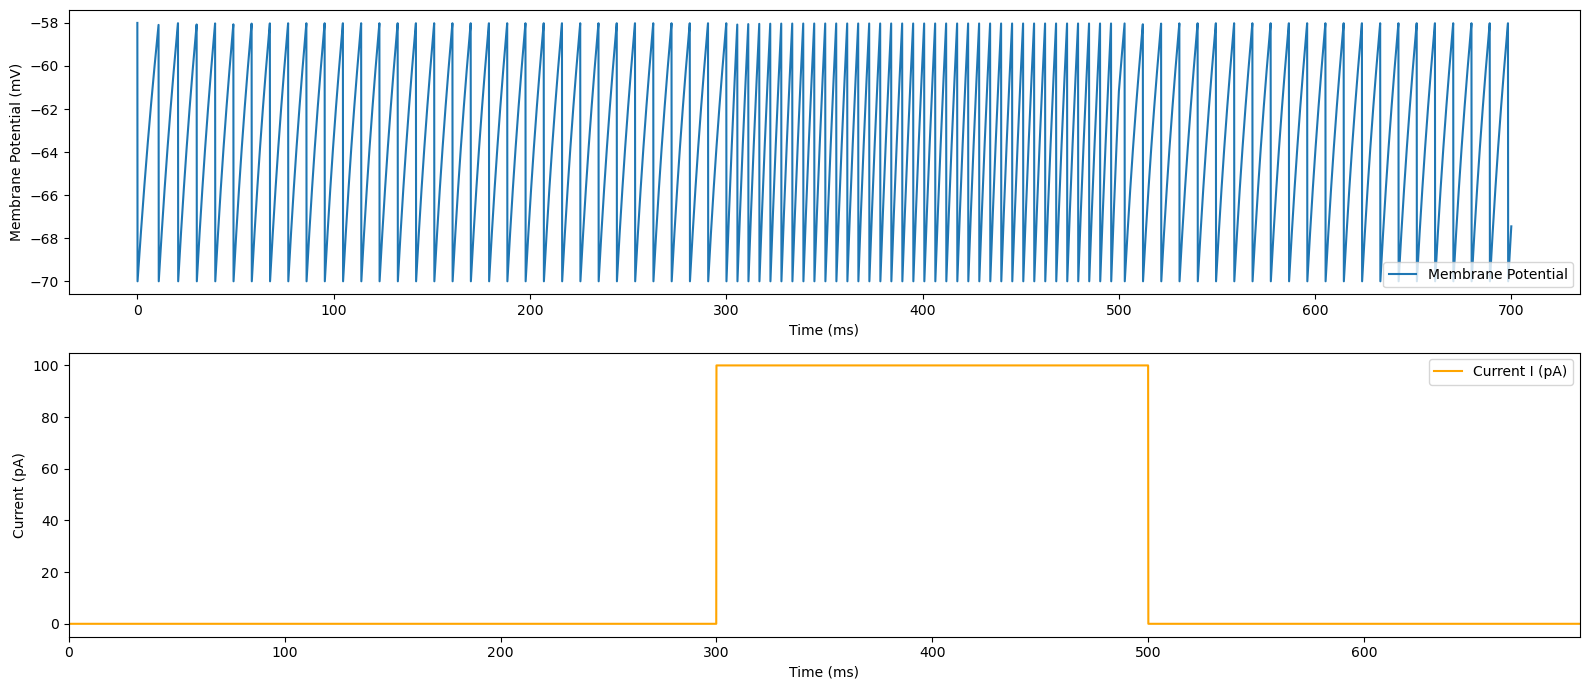

In [ ]:
### Adaptive Exponential Integrate and Fire (v = threshold)
json_file = './AdEx2.json'  

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -10. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


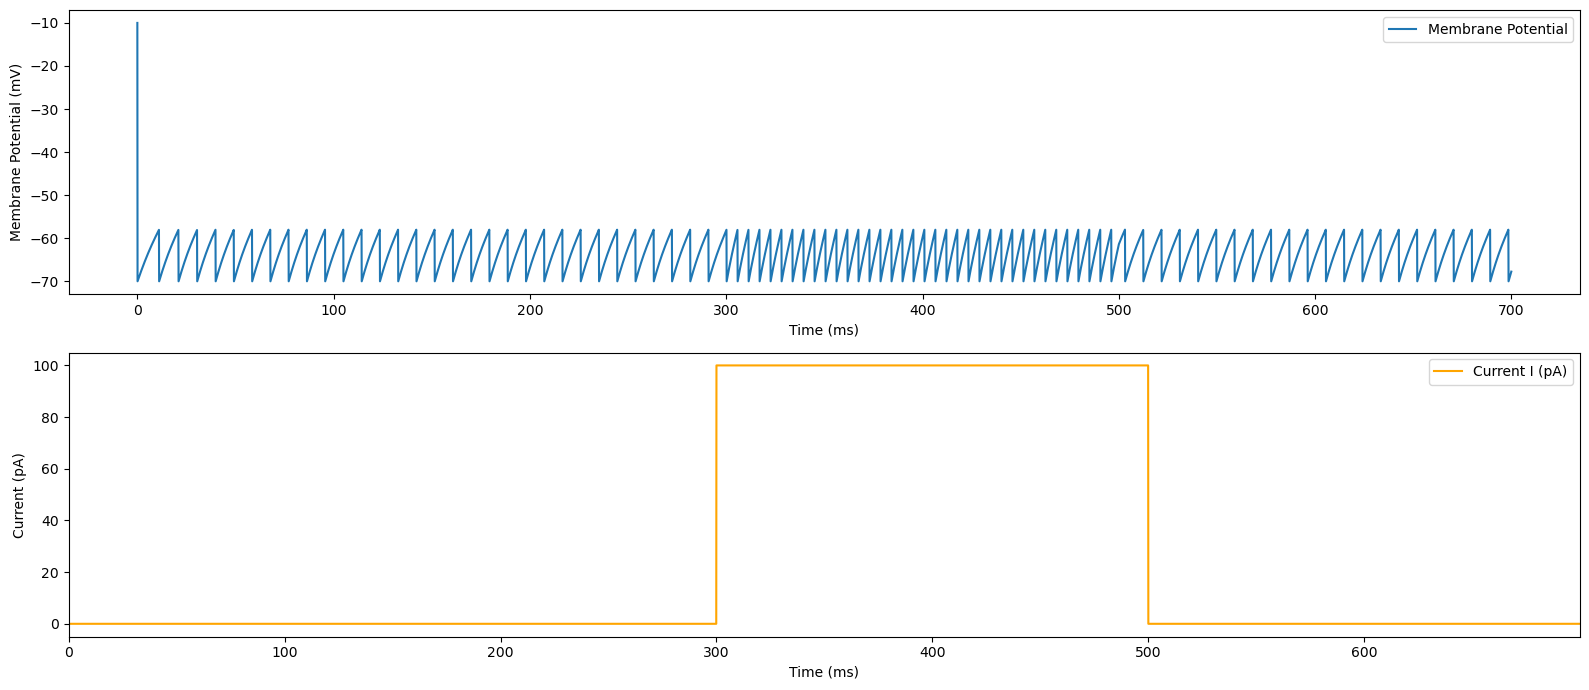

In [ ]:
### Adaptive Exponential Integrate and Fire (v > threshold)
json_file = './AdEx2.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

Converted parameters: {'g_L': 12. * nsiemens, 'E_L': -58. * mvolt, 'Delta_T': 7. * mvolt, 'vt': -58. * mvolt, 'v': -100. * mvolt, 'vr': -70. * mvolt, 'tau_w': 12. * msecond, 'a': 8. * nsiemens, 'd': 3. * pamp, 'C': 115. * pfarad, 'I': 100. * pamp}


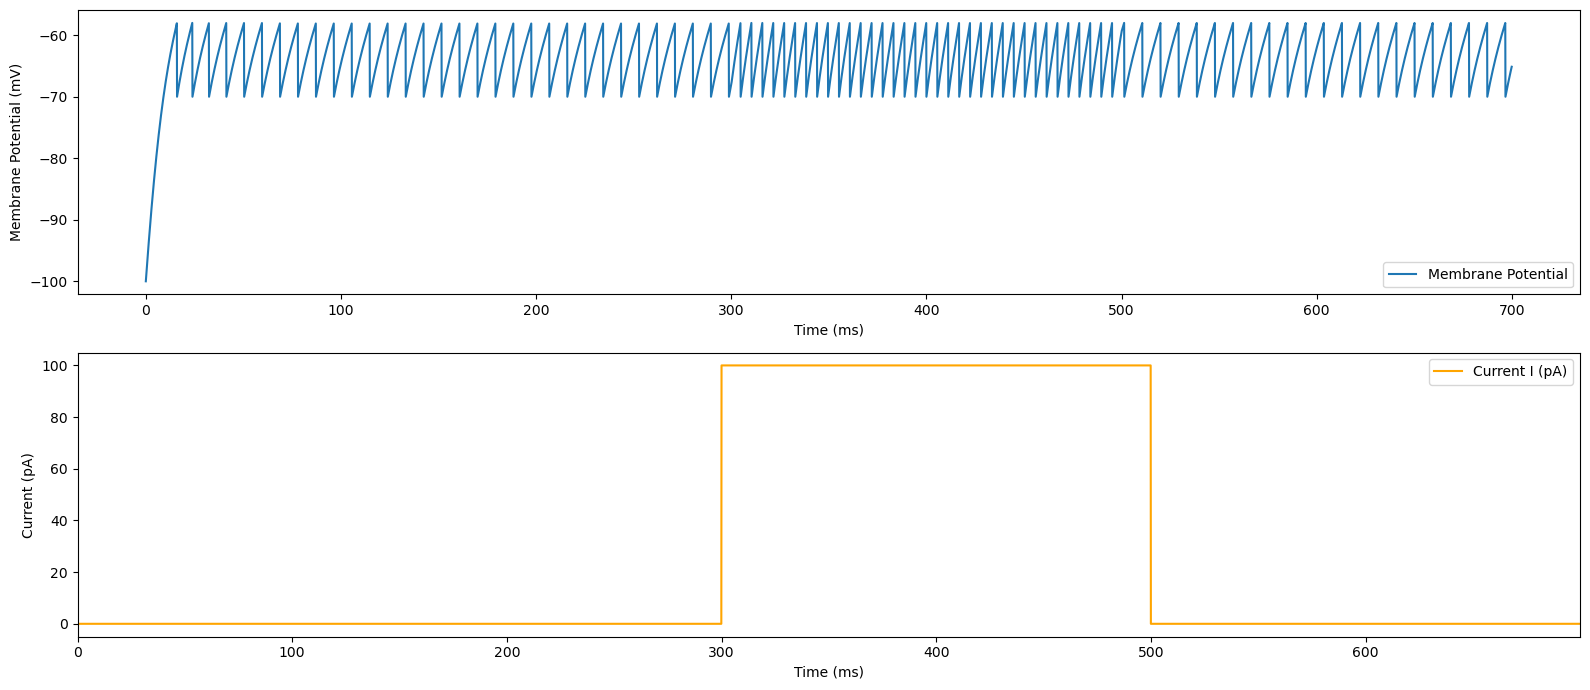

In [ ]:
### Adaptive Exponential Integrate and Fire (v < threshold)
json_file = './AdEx2.json' 

# load parameters
params, model_name = load_params(json_file)
N = params.pop('N')['value']  

# simulation 
sim = run_simulation(N, params, model_name)

# visualization
sim.plot_results()

### Monitoring with different I

In [1]:
### import packages 
from brian2 import *
from brian2.units import *
from brian2 import ms
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from simulation_I import run_simulation, load_params, plot_results

Running simulation with I=-90. pA for injection_start_time=200. ms ms and duration=100 ms


INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_772l1wbz
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

Running simulation with I=-90. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=-90. pA for injection_start_time=200. ms ms and duration=300 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -60. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -60. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=-60. pA for injection_start_time=200. ms ms and duration=100 ms
Running simulation with I=-60. pA for injection_start_time=200. ms ms and duration=200 ms


WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value -30. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=-60. pA for injection_start_time=200. ms ms and duration=300 ms
Running simulation with I=-30. pA for injection_start_time=200. ms ms and duration=100 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -30. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=-30. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=-30. pA for injection_start_time=200. ms ms and duration=300 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=0. A for injection_start_time=200. ms ms and duration=100 ms
Running simulation with I=0. A for injection_start_time=200. ms ms and duration=200 ms


WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 30. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=0. A for injection_start_time=200. ms ms and duration=300 ms
Running simulation with I=30. pA for injection_start_time=200. ms ms and duration=100 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 30. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=30. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=30. pA for injection_start_time=200. ms ms and duration=300 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 60. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 60. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=60. pA for injection_start_time=200. ms ms and duration=100 ms
Running simulation with I=60. pA for injection_start_time=200. ms ms and duration=200 ms


WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 90. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=60. pA for injection_start_time=200. ms ms and duration=300 ms
Running simulation with I=90. pA for injection_start_time=200. ms ms and duration=100 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 90. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=90. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=90. pA for injection_start_time=200. ms ms and duration=300 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 120. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 120. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=120. pA for injection_start_time=200. ms ms and duration=100 ms
Running simulation with I=120. pA for injection_start_time=200. ms ms and duration=200 ms


WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 150. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=120. pA for injection_start_time=200. ms ms and duration=300 ms
Running simulation with I=150. pA for injection_start_time=200. ms ms and duration=100 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 150. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=150. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=150. pA for injection_start_time=200. ms ms and duration=300 ms


WARNING    'I' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 180. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 180. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Running simulation with I=180. pA for injection_start_time=200. ms ms and duration=100 ms
Running simulation with I=180. pA for injection_start_time=200. ms ms and duration=200 ms
Running simulation with I=180. pA for injection_start_time=200. ms ms and duration=300 ms


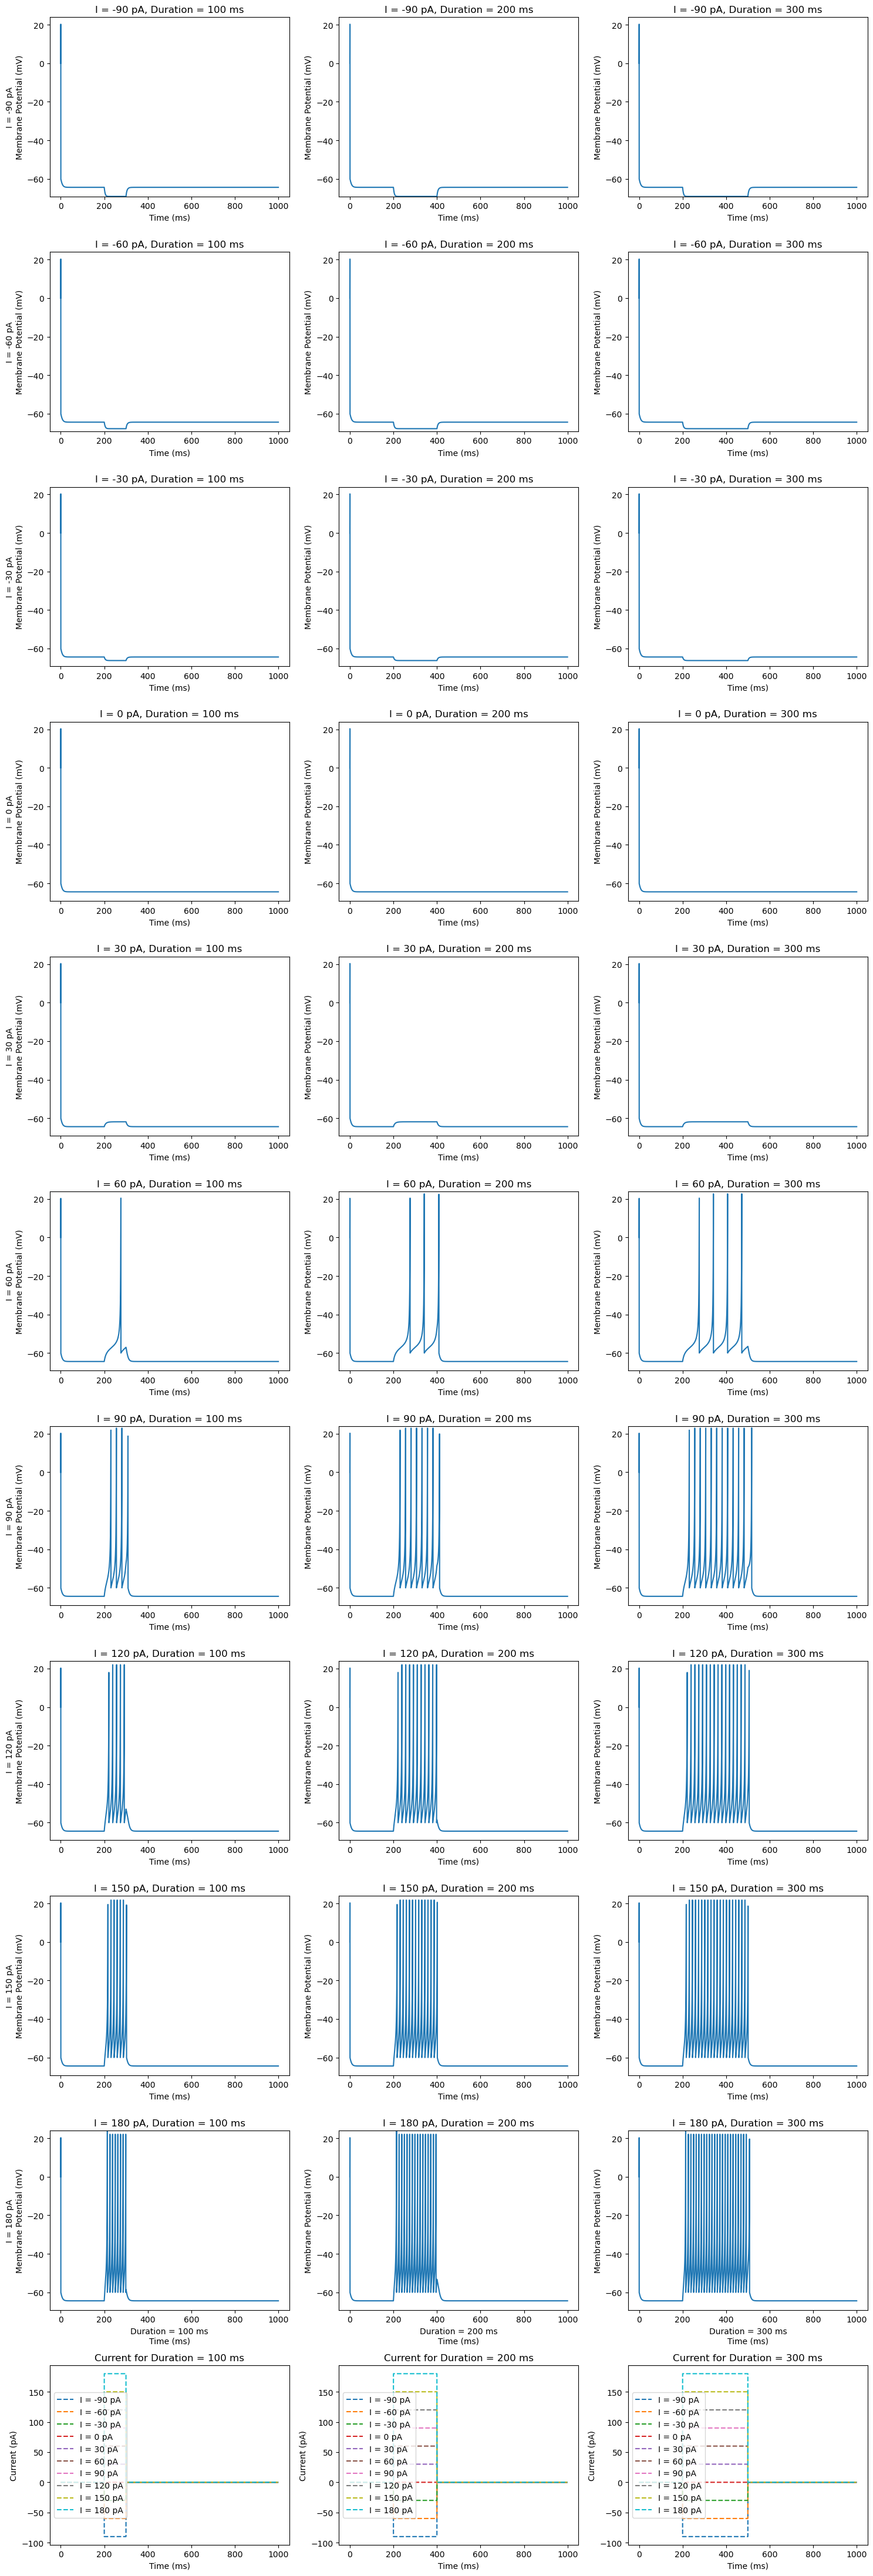

In [2]:
### v: 0mV
json_file = './params_ref/FSN_1.json'  

# Load parameters
params, model_name = load_params(json_file)

N = params.pop('N')['value']  
I_values = [-90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
durations = [100, 200, 300]  

# Run simulation
all_results, all_currents, total_time, injection_times = run_simulation(
    N, params, model_name, I_values, durations, injection_start_time = 200 * ms
)
# Plot results
plot_results(all_results, all_currents, I_values, total_time, injection_times, durations)

INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_16_pmm6h
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

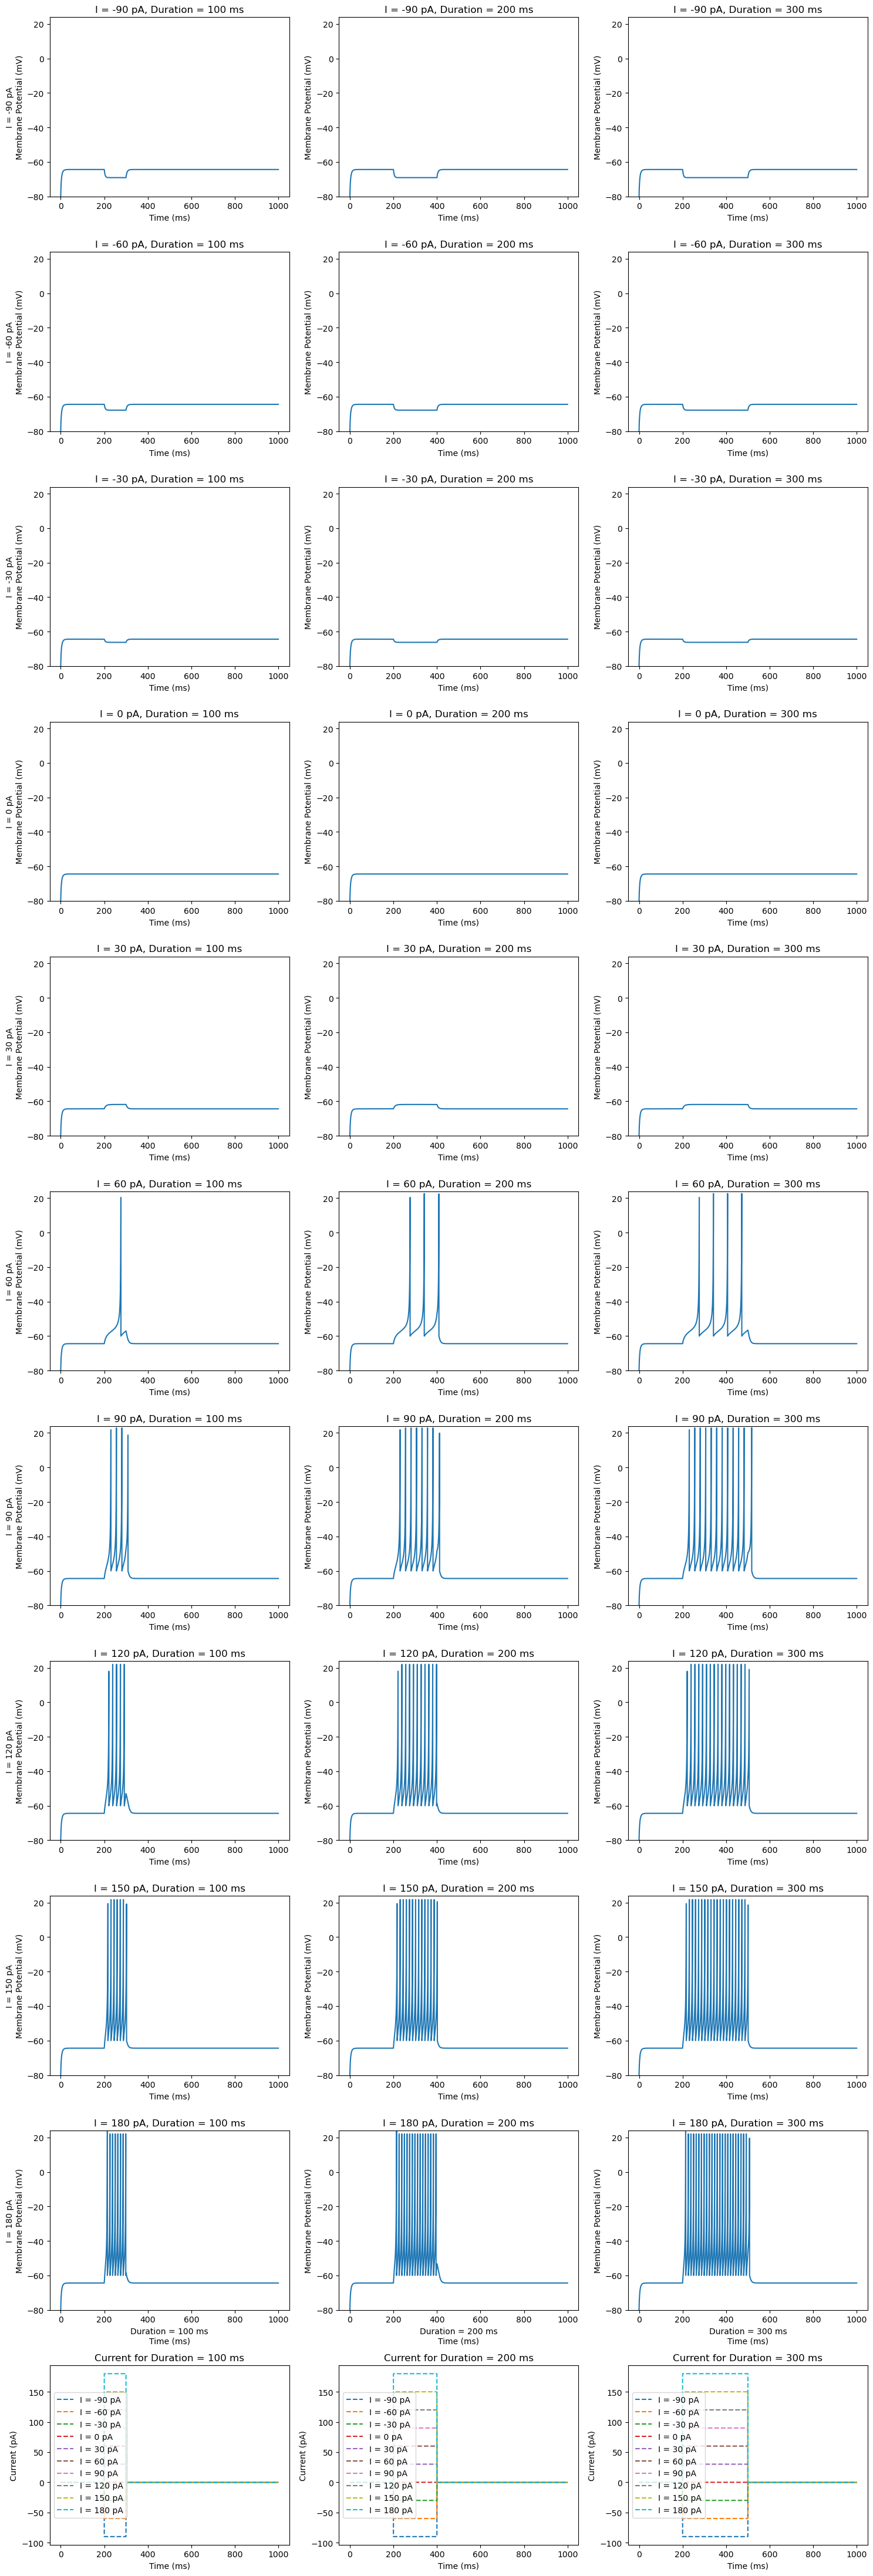

In [3]:
### v: -80mV
json_file = './params_ref/FSN_1.json'  

# Load parameters
params, model_name = load_params(json_file)

N = params.pop('N')['value']  
I_values = [-90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
durations = [100, 200, 300]  

# Run simulation
all_results, all_currents, total_time, injection_times = run_simulation(
    N, params, model_name, I_values, durations, injection_start_time = 200 * ms
)
# Plot results
plot_results(all_results, all_currents, I_values, total_time, injection_times, durations)

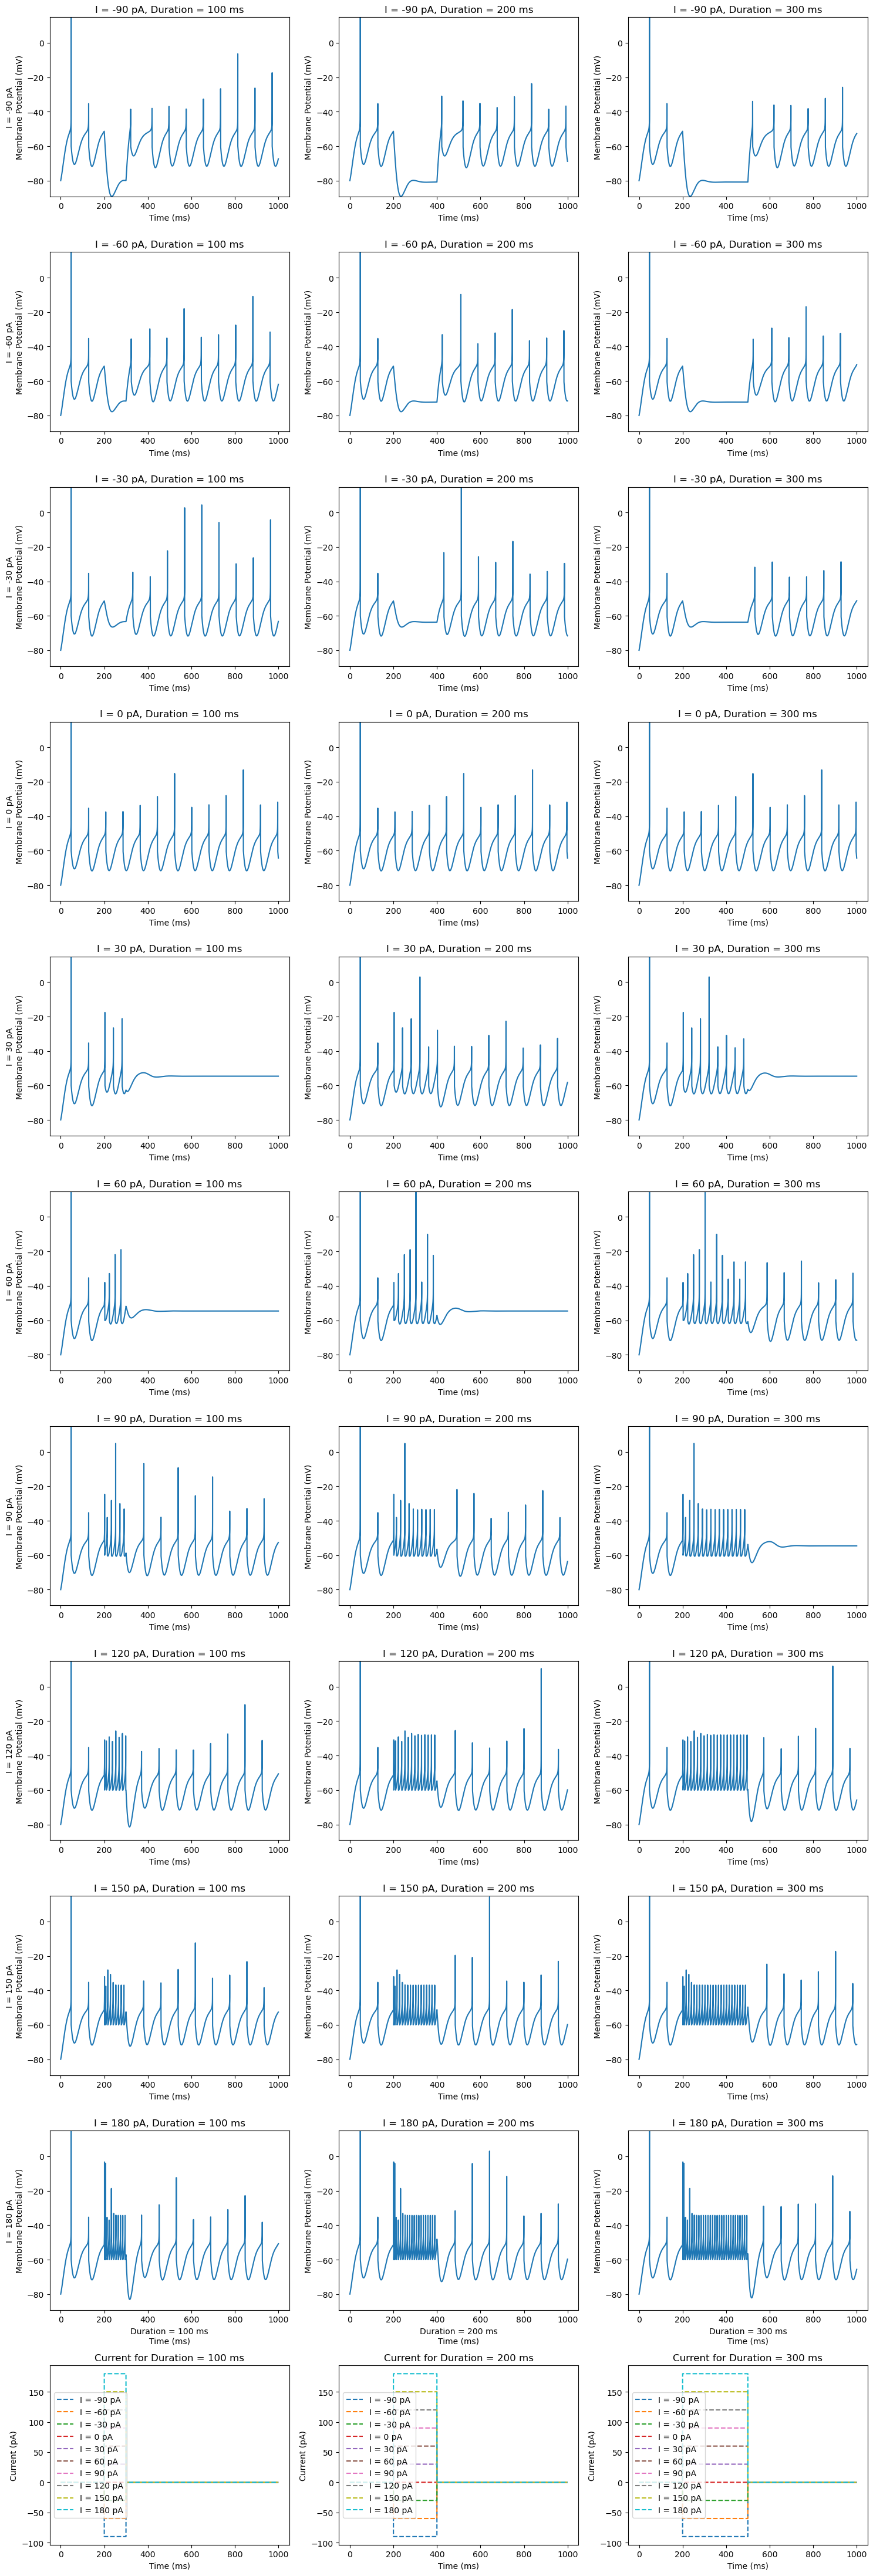

In [5]:
json_file = './params_ref/GPe_T1_1.json'  

# load parameters
params, model_name = load_params(json_file)

N = params.pop('N')['value']  
I_values = [-90, -60, -30, 0, 30, 60, 90, 120, 150, 180]
durations = [100, 200, 300]  # Example durations in ms

# Run simulation
all_results, all_currents, total_time, injection_times = run_simulation(
    N, params, model_name, I_values, durations, injection_start_time = 200 * ms
)
# Plot results
plot_results(all_results, all_currents, I_values, total_time, injection_times, durations)